# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Badyn Milstein-Touesnard, Isabel Camara, Mateo Aranzazu

**ID**: 5286287, 5273977, 5355552

**netID**: bmm98, ic277, ma956

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/bee4750/homework/hw5-ismabay`


In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

### Decision Variables

The decision variables in this waste management problem are $W_{i,j}$, $R_{k,j}$, and $Y_j$, where $W_{i,j}$ is the waste transported from city $i$ to disposal $j$ in Mg/day, $R_{k,j}$ is the residual waste transported from disposal $k$ to disposal $j$ in Mg/day, and $Y_j$ is the operational status of disposal $j$ (binary variable).

 ### Objective

The objective of this model is to minimze costs: waste disposal and transportation costs. Costs inlcude fixed cost, tipping fee, recyling cost, and transport costs.

LF = 1, MRF = 2, WTE = 3

**For landfill costs:**

$2000 * Y_1 + 50 * (W_{1,1} + W_{2,1} + W_{3,1} + R_{2,1}+ R_{3,1})$

**For MRF costs:**

$1500 * Y_2 + 7 * (W_{1,2} + W_{2,2} + W_{3,2} + (.4 * 40 * ((W_{1,2} + W_{2,2} + W_{3,2}))))$

**For Waste to Energy costs:**

$2500 * Y_3 + 60*(W_{1,3} + W_{2,3} + W_{3,3}+ R_{2,3})$

**For transportation costs:**

$1.5 * [5 * W_{1,1} + 30 * W_{1,2} + 15 * W_{1,3} + 15 * W_{2,1} + 25 * W_{2,2} + 10 * W_{2,3} + 13 * W_{3,1} + 45 * W_{3,2} + 20 * W_{3,3} + 32 * R_{2,1} + 18 * W_{3,1} + 15 * W_{2,3}]$

**Final Objective**

Combining the transportation and disposal costs and simplifying:

$min_{W,R,Y} = 57.5W_{1,1} + 72.5W_{2,1} + 69.5W_{3,1} + 68W_{1,2} + 60.5W_{2,2} + 90.5W_{3,2} + 82.5W_{1,3} + 75W_{2,3} + 90W_{3,3} + 82R_{2,1} + 50R_{3,1} + 60R_{2,3} + 2000Y_1 + 1500Y_2 + 2500Y_3$

**Constraints:**

Disposal Production Constraint:

$ W_{1,1} + W_{1,2} + W_{1,3} = 100$

$ W_{2,1} + W_{2,2} + W_{2,3} = 90$

$ W_{3,1} + W_{3,2} + W_{3,3} = 120$

Non-recycled waste that entered MRF must equal waste from MRF:

$ R_{2,3} + R_{2,1} = [W_{1,2} + W_{2,2} + W_{3,2}]*[1-0.4]$

Waste from WTE must equal ash produced:

$ R_{3,1} = [W_{1,1} + W_{2,1} + W_{3,1}]*(0.16) + R_{2,3} * (0.14)$

Disposal Facility Capacity Constraint:

$ W_{1,1} + W_{2,1} + W_{3,1} + R_{2,1} + R_{3,1} <= 200$

$ W_{1,2} + W_{2,2} + W_{3,2} <= 350$

$ W_{1,3} + W_{2,3} + W_{3,3} + R_{2,3} <= 210$

Ensure Operational Status is Binary Variable Constraint: 

If $\sum_{i\in I} W_{ij} = 0$

$ Y_j = 0 $

If $\sum_{i\in I} W_{ij} >= 0$

$ Y_j = 1 $


In [3]:
#defining givens into variables


#facility fees and info 
facility = ["landfill", "MRF", "WTE"]
max = [200, 350, 210] #units of Mg
Cf = [2000, 1500, 2500] #units of $/day - fixed cost
Ctip = [50,7,60] #units of $/Mg tipping cost
Cr = [0,40,0] #units of $/Mg recycling cost
Ct = 1.5 #units of $/mg-km transpot cost

#distance breakdown
cities = ["City 1", "City 2", "City 3"]
distance = 
city_1_distance = [5,30,15]
city_2_distance = [15,25,10]
city_3_distance = [13,45,20]
LF_distance = [0,32,18]
MRF_distance = [32,0,15]
WTE_distance = [18,15,0]

#[[5, 30, 5];; [15,25,10];; [13,45,20]]
Dw = [[5, 15, 13];; [30, 25, 45];; [15, 10, 20]]
# waste distance to city
Dr = [[0,32,18];; [32,0,15];; [18,15,0]]     # dist between waste centers

MRF_recycle = .4
ash_fraction = .16
reclycing_fraction = .14

@show Dw[2,1]

Dw[2, 1] = 15


15

In [4]:
waste_model = Model(HiGHS.Optimizer);

I = 1:length(cities)
J = 1:length(facility)
K = 1:3

@variable(waste_model, W[i in I, j in J] >= 0) # non-negativity constraints for 9 variables
@variable(waste_model, R[k in J, j in J] >= 0) # R21, R23, R31
@variable(waste_model, Y[j in J], Bin) # operational status

@objective(waste_model, Min, sum([57.5 68 82.5; 72.5 60.5 75; 69.5 90.5 90] .*W)+sum([0 0 0; 82 0 60; 50 0 0] .*R)+sum([2000, 1500, 2500] .*Y))
#@objective(waste_model, Min, sum([57.5 72.5 69.5; 68 60.5 90.5; 82.5 75 90] .*W)+sum([0 0 0; 82 0 60; 50 0 0] .*R)+sum([2000, 1500, 2500] .*Y))


@constraint(waste_model, city_1, W[1,1]+ W[1,2] + W[1,3] == 100)
@constraint(waste_model, city_2, W[2,1]+ W[2,2] + W[2,3] == 90)
@constraint(waste_model, city_3, W[3,1]+ W[3,2] + W[3,3] == 120)

@constraint(waste_model, residual_1, R[2,3]+ R[2,1] == .6 .* (W[1,2]+ W[2,2] + W[3,2]))
@constraint(waste_model, residual_2, R[3,1] == (.16 .* W[1,1]+ W[2,1] + W[3,1]) + (.14 .* R[2,3]))

@constraint(waste_model, LF, W[1,1]+ W[2,1] + W[3,1] + R[2,1]+R[3,1] <= 200)
@constraint(waste_model, MRF, W[1,2]+ W[2,2] + W[3,2] <= 350)
@constraint(waste_model, WTE, W[1,3]+ W[2,3] + W[3,3] + R[2,3] <= 210)

@constraint(waste_model, binary1, !Y[3] => {W[1,1] + W[1,2] + W[1,3] + R[2,1] + R[3,1] == 0})
@constraint(waste_model, binary2, !Y[2] => {W[2,1] + W[2,2] + W[2,3] == 0})
@constraint(waste_model, binary3, Y[1] == 1)

binary3 : Y[1] = 1

In [5]:
optimize!(waste_model)


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms


ErrorException: Unable to use IndicatorToMILPBridge because element 2 in the function has a non-finite domain: 0.0 + 1.0 MOI.VariableIndex(1) + 1.0 MOI.VariableIndex(4) + 1.0 MOI.VariableIndex(7) + 1.0 MOI.VariableIndex(11) + 1.0 MOI.VariableIndex(12)

In [6]:
I = 1:3
J = 1:3

waste_model = Model(HiGHS.Optimizer);


# @variable(waste_model, W[1:3, 1:3] >= 0) # non-negativity constraints for 9 variables
# @variable(waste_model, R[1:3, 1:3] >= 0) # R21, R23, R31
# @variable(waste_model, Y[1:3], Bin) # operational status

@variable(waste_model, W[i in I, j in J] >= 0) # non-negativity constraints for 9 variables
@variable(waste_model, R[i in I, j in J] >= 0) # R21, R23, R31
@variable(waste_model, Y[j in J], Bin) # operational status


@objective(waste_model, Min, (sum(W[c,f]*Ctip[c] + W[c,f]*Cr[c] + W[c,f]*Dw[c,f] + R[c,f]*Dr[c,f] for c in I, f in J)) + sum(Y[j]*Cf[j] for j in J))

#@objective(waste_model, Min, sum(Y[j]*Cf[j] + sum(W[i,j] * (Ctip[j] + Ct*Dw[i,j]) for i in I) + sum(R[k,j] * (Ctip[j] + Ct*Dr[k,j]) for k in J) for j in J) + sum(MRF_recycle*Cr*W[i,2] for i in I))


@constraint(waste_model, city_1, (sum(W[1,j] for j in J)) == 100)
@constraint(waste_model, city_2, (sum(W[2,j] for j in J)) == 90)
@constraint(waste_model, city_3, (sum(W[2,j] for j in J)) == 120)

@constraint(waste_model, LF_tot,  (sum(W[i,1] for i in I)) <= max[1])
@constraint(waste_model, MRF_tot, (sum(W[i,2] for i in I)) <= max[2])
@constraint(waste_model, WTE_tot, (sum(W[i,3] for i in I)) <= max[3])

@constraint(waste_model, Refuse, (sum(W[i,3] for i in I))*0.6 == R[2,1] + R[2,3])
@constraint(waste_model, Secondary_refuse, (sum(W[i,3] for i in I))*1.6 + R[2,3]*1.4 == R[3,1])

# @constraint(waste_model, binary_off, (sum(W[3,j] for j=1:3)) <= max[3])
# @constraint(waste_model, binary_on,  (sum(W[3,j] for j=1:3)) <= max[3])
# did not change yet
@constraint(waste_model, binary1, !Y[3] => {W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] == 0})
@constraint(waste_model, binary2, !Y[2] => {W[1,2] + W[2,2] + W[3,2] == 0})
@constraint(waste_model, binary3, Y[1] == 1)

#  {W[3,1] + W[3,2] + W[3,3] +  == 0}




binary3 : Y[1] = 1

In [7]:
optimize!(waste_model)


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms


ErrorException: Unable to use IndicatorToMILPBridge because element 2 in the function has a non-finite domain: 0.0 + 1.0 MOI.VariableIndex(1) + 1.0 MOI.VariableIndex(2) + 1.0 MOI.VariableIndex(3) + 1.0 MOI.VariableIndex(11) + 1.0 MOI.VariableIndex(12)

### **Diagram showing the flows of waste between the cities and the facilities**
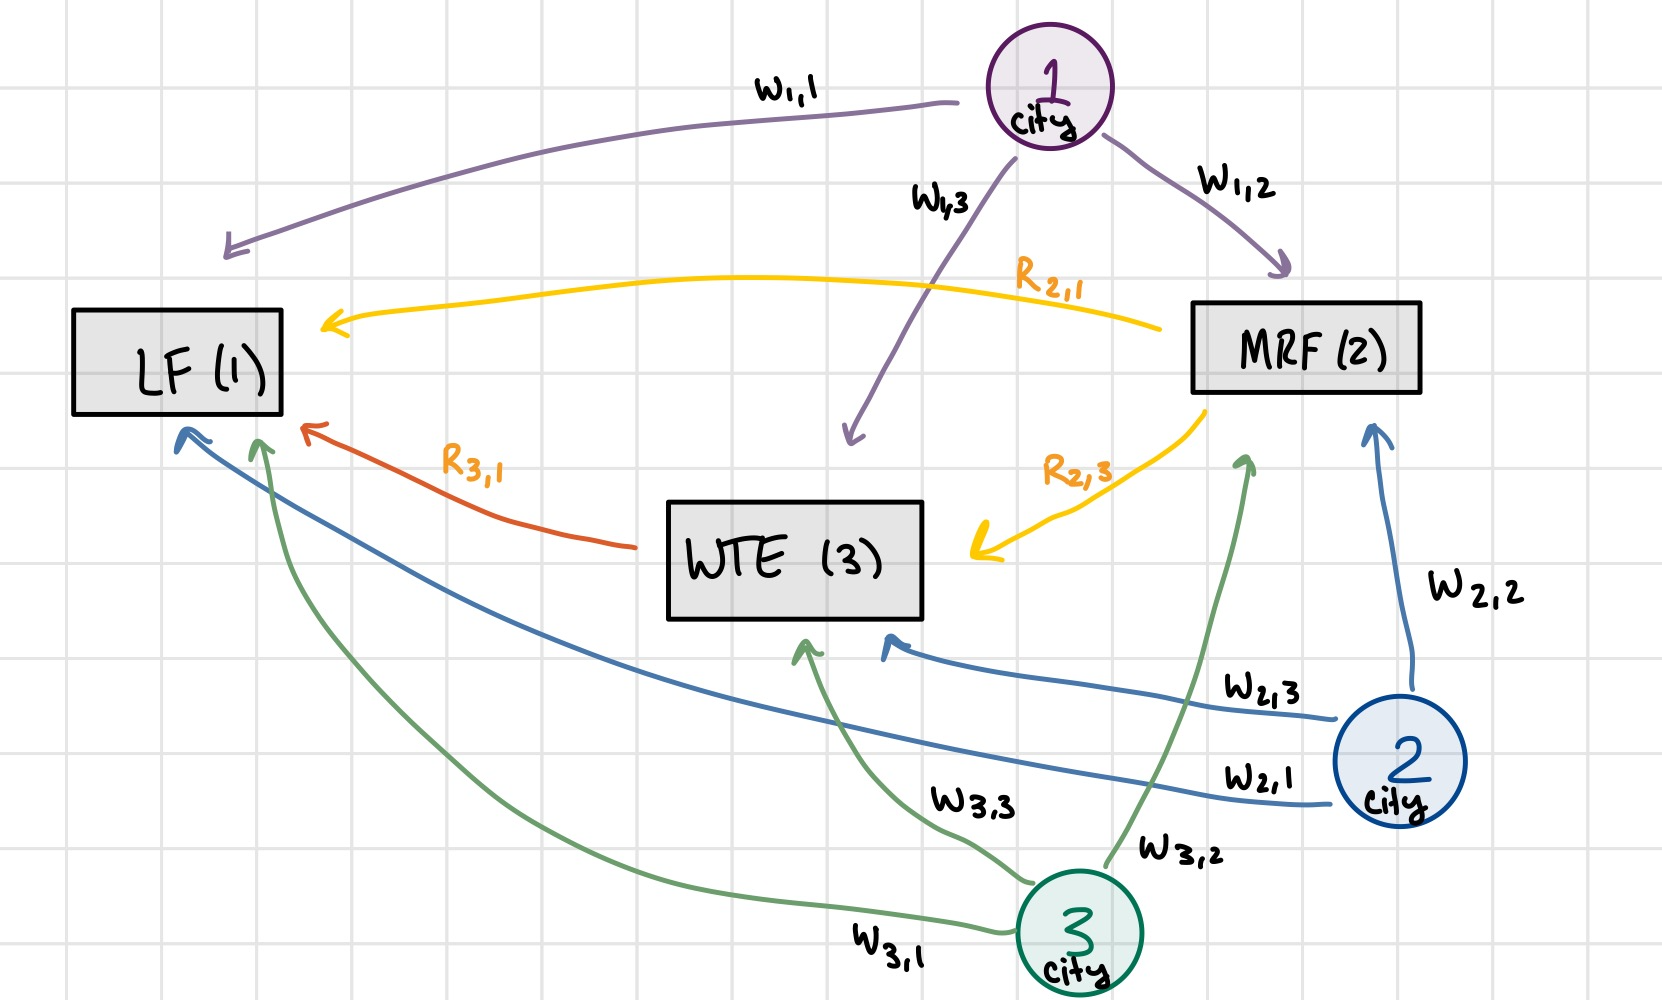


the operational status of facilities is determined by the binary variables  $𝑌_𝑗$. Facilities with $Y_j = 0$ are not used. The model ensures all waste is managed while minimizing costs, so any unused facility would result from it being less cost-effective due to higher fixed costs, tipping fees, or transportation distances

## References

List any external references consulted, including classmates.